In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
def read_data(File_path):
    # Open the file
    file = open(File_path, 'r')

    # Split the text data into lines
    lines = file.readlines()

    # Extract the column names from the header line
    column_names = lines[0].strip().split('|')
    column_names = [col.strip() for col in column_names]

    # Create a list of rows
    rows = []
    for line in lines[2:]:  # Skip the header and column names lines
        if line.strip():
            #row = line.strip().split()
            # only for the data set main 2 file.
            row = line.strip().replace('0.00001-', '0.00001 ').split()
            rows.append(row)
    # Create a pandas DataFrame from the list of rows
    data = pd.DataFrame(rows, columns=column_names)
    # Convert the data types of the columns
    data = data.astype({
                        'absolute angle of inclination': float, 'angle of inclination': float, 'number of electrodes': float,
                        'voltage magnitude': float, 'voltage frequency': float,'electrode dimension': float,
                        'x pitch': float, 'number of phases': float, 'grain mass density': float,
                        'mesh size': float, 'gravity': float, 'phase shift': float,
                        'maximum classified radius': float,'distance between dust generation and first electrode': float,
                        'yield': float
    })
    return data

In [12]:
Folder_name = "Sample Dataset"
File_name1 = "data_set_main1.txt"
File_name2 = "data_set_main2.txt"
File_name5 = "data_set_mains5.txt"

File_path1 = os.path.join(Folder_name, File_name1)
File_path2 = os.path.join(Folder_name, File_name2)
File_path5 = os.path.join(Folder_name, File_name5)

data1 = read_data(File_path1)
data2 = read_data(File_path2)
data5 = read_data(File_path5)



data = pd.concat([data1, data2, data5], ignore_index=True)

data

,absolute angle of inclination,angle of inclination,number of electrodes,voltage magnitude,voltage frequency,electrode dimension,x pitch,number of phases,grain mass density,mesh size,gravity,phase shift,maximum classified radius,distance between dust generation and first electrode,yield
0,355.0,5.0,3.0,1000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.007250,0.126490
1,355.0,5.0,4.0,1000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.006375,0.092699
2,355.0,5.0,5.0,1000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.005500,0.082674
3,355.0,5.0,6.0,1000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.009626,0.175985
4,355.0,5.0,2.0,1000.0,10.0,3.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.007625,0.356726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,360.0,0.0,10.0,2000.0,10.0,3.0,25.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.003500,5.148757
5616,345.0,15.0,10.0,2000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.009885,5.838564
5617,345.0,15.0,10.0,2000.0,10.0,3.0,25.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.008356,8.673150
5618,330.0,30.0,10.0,2000.0,10.0,2.0,20.0,4.0,2650.0,0.001,9.81,90.0,0.00001,0.012038,4.840568


In [13]:
numeric_features = ['absolute angle of inclination', 'number of electrodes', 'electrode dimension',
                    'x pitch', 'distance between dust generation and first electrode', 'voltage magnitude',
                    'voltage frequency', 'grain mass density', 'gravity', 'mesh size',
                    ]

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row[numeric_features].values.astype(np.float32)
        target = row['yield'].astype(np.float32)
        return features, target

In [14]:
dataset = CustomDataset(data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [19]:
hidden_layer_size = 32
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(numeric_features), hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
def rmse_loss(outputs, targets):
    return torch.sqrt(F.mse_loss(outputs, targets.unsqueeze(1)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


model = Net().to(device)
model = model.float()
criterion = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset.to_device = to_device
val_dataset.to_device = to_device

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

epochs = 100
train_losses = []
val_losses = []

Using cuda device


In [21]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}', end=" ")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Test Loss: {val_loss:.6f}')

Epoch 1, Train Loss: 1.494993 Val Loss: 0.394355
Epoch 2, Train Loss: 0.432110 Val Loss: 0.435913
Epoch 3, Train Loss: 0.434578 Val Loss: 0.382168
Epoch 4, Train Loss: 0.408610 Val Loss: 0.434176
Epoch 5, Train Loss: 0.385842 Val Loss: 0.378850
Epoch 6, Train Loss: 0.373510 Val Loss: 0.359756
Epoch 7, Train Loss: 0.370310 Val Loss: 0.379468
Epoch 8, Train Loss: 0.385917 Val Loss: 0.373797
Epoch 9, Train Loss: 0.369870 Val Loss: 0.369780
Epoch 10, Train Loss: 0.363538 Val Loss: 0.459384
Epoch 11, Train Loss: 0.366162 Val Loss: 0.363883
Epoch 12, Train Loss: 0.368610 Val Loss: 0.375891
Epoch 13, Train Loss: 0.364247 Val Loss: 0.391972
Epoch 14, Train Loss: 0.361575 Val Loss: 0.359447
Epoch 15, Train Loss: 0.361831 Val Loss: 0.365324
Epoch 16, Train Loss: 0.365151 Val Loss: 0.368661
Epoch 17, Train Loss: 0.364720 Val Loss: 0.365910
Epoch 18, Train Loss: 0.361269 Val Loss: 0.373384
Epoch 19, Train Loss: 0.362681 Val Loss: 0.379831
Epoch 20, Train Loss: 0.361087 Val Loss: 0.346595
Epoch 21,

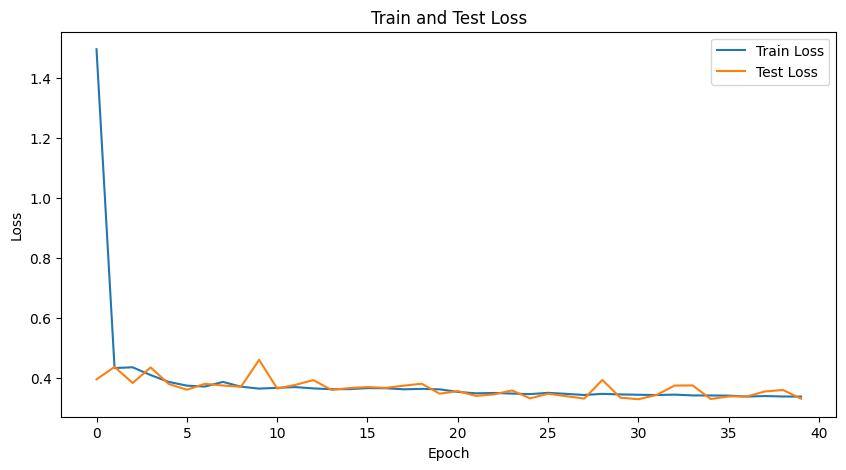

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()